## Lab 4 - part 2: Data Weights and Autocorellation

**TU Delft and WUR**<br>
**Q1 2024**<br>
**Instructor:** Theodoros Chatzivasileiadis <br>
**Instructor:** Hans Hoogenboom <br>
**TA:** Ka Yi Chua <br>
**[Metropolitan Data 1](https://jhoogenboom.github.io/spatial-data-science/_index.html)** <br>



## Exercise 4a: Spatial Autocorrelation and ESDA 

USE the Liverpool IMD data we have been using in previous sessions. This will require you to:

* Load up the IMD dataset for Liverpool.
* Create a choropleth of the `imd_score` variable.
* Compute the spatial weights matrix for the LSOAs. Think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.
* Create the standardized version of the IMD scores.
* Calculate the spatial lag of the standardized scores.
* Create the Moran Plot.
* Calculate the value of Moran's I as well as its significance level.
* Perform a LISA analysis and generate a map of the results. What are the main patterns?

For this part I would like you to experiment with Data from Amstedam. However this will require you to find the dataset yourself!

## Question 1: Building a Contiguity-Based Weight Matrix

Use PySAL to create a contiguity-based weight matrix (W) for a given spatial dataset of polygons. Write a function create_contiguity_weights that:

    Reads in a shapefile of polygons.
    Constructs a Queen contiguity-based spatial weights matrix.
    Returns the weight matrix.

## Question 2: Calculating Moran’s I

Write a function calculate_morans_i that:

    Takes a spatial weight matrix W and an attribute array y.
    Calculates Moran’s I for the given attribute array.
    Returns the Moran’s I value and its p-value.

## Question 3: Standardizing Spatial Weight Matrices

Create a function standardize_weights that:

    Takes a spatial weight matrix W.
    Standardizes it so that the weights of each row sum to one.
    Returns the standardized weight matrix.

## Question 4: Creating Distance-Based Weights

Write a function create_distance_weights that:

    Takes a set of point coordinates and a threshold distance.
    Constructs a distance-based spatial weight matrix where all points within the threshold distance are assigned a weight.
    Returns the weight matrix.

## Question 5: Visualizing a Moran Plot

Using PySAL, write a function plot_moran that:

    Takes a spatial weights matrix W and an attribute array y.
    Creates and displays a Moran plot for the attribute.
    Saves the Moran plot as an image file.

In [1]:
# import all the neccesary libraries
import seaborn as sns
import pandas as pd
import pysal as ps
from pysal.lib import weights
from libpysal.io import open as psopen
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
from pysal.explore import esda 

c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Answers 

### Question 1

In [2]:
# Read in a shapefile of polygons. This particular shapefile is about sportfields in Amsterdam
sportsvelden = gpd.read_file('data/amsterdam/Sportvelden 05122019.shp')

# Constructs a Queen contiguity-based spatial weights matrix using a function. GUID is the ID column
def create_contiguity_weights(x):
    w_queen = weights.Queen.from_dataframe(sportsvelden, ids='GUID')
    return (w_queen[x])
print (create_contiguity_weights('{29C40179-1AD9-4061-ADBD-5A23F6D40726}')) # Checking if the def works by choosing a random polygon  
# We picked an ID that apparantly shares boundaries with 2 other polygons, those 'neighboring' ID's are printed. The "1.0" refers to Queen contiguity, which means that two polygons are considered neighbors if they 
# touch at any point


{'{69267C62-AB89-438C-BFCB-A396F5D1565A}': 1.0, '{77E089FA-5C8C-4CE4-90D7-6C5438E88EE9}': 1.0}


c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 446 disconnected components.
 There are 340 islands with ids: {F161AD0A-399D-4CCD-8E7E-ADBBE9CCAFB6}, {A422479A-24BD-4566-89F4-30D07091A2CA}, {9991F3F0-214A-4423-A7B1-EE02DA16CBF0}, {E048E5E2-DE58-454D-AA39-E255D5D194C9}, {5C280F7C-C064-4F8D-8F81-29AB8EA8D350}, {B37D32AB-BEF6-4210-9EF0-E7F160A1B152}, {C696C291-3C9D-4E7D-9146-5E903F466B8A}, {9453F2E7-14DA-48E3-80E3-A62995E0ECFF}, {B5223944-E3FF-44C2-A38F-DFE83F9239D6}, {E31C20F1-5B11-4235-A997-B64BC2B36B85}, {D6276427-8895-4FB0-A299-4E8E864DEAB8}, {939952B1-2694-418F-A52D-8A099BF46EBA}, {8F6E34DE-535D-4668-ACB7-265C27E13B4B}, {FC561271-1C1C-40BD-8487-642B2991A452}, {EB9A9BFC-A44A-4007-8331-B7EFE188C966}, {66BF7067-5976-475C-AAB7-5EB67B7947A1}, {736C9EDA-0ECC-444B-BF98-386231DB1384}, {160F4BE4-D3A4-40E6-B0B6-4CC0949FF120}, {DB134253-7A08-4A18-9960-C21D70EB71DA}, {

In [3]:
#ALTERNATIVE WAY OF DOING IT
# in case we are not able to look for the file in advance, this can be a unique method for all of the shape files
# but in this case the identificator column can not be set inside the function

# We downloaded the shape file of the sport grounds of Amsterdam from the site of teh Gemeente:
sportvelden = gpd.read_file('data/amsterdam/Sportvelden 05122019.shp')  
w_queen = weights.Queen.from_dataframe(sportvelden, ids='GUID')  
print('The neighbors of this strange name sportground are: ', w_queen ['{8FED7F2A-9EDD-43B5-9677-B2F0FAE09EE5}'])   

def create_contiguity_weights(shp_file):
    polygons = gpd.read_file(shp_file)
    w_queen = weights.Queen.from_dataframe(polygons)

    return (w_queen)

create_contiguity_weights('data/amsterdam/Sportvelden 05122019.shp')

The neighbors of this strange name sportground are:  {'{35727819-7F8D-4C18-9D0C-B6FD5DA946BC}': 1.0, '{8AC7B0A5-8F5F-4B46-91DA-2DDB35506994}': 1.0}


C:\Users\maria\AppData\Local\Temp\ipykernel_19900\1517275794.py:12: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_queen = weights.Queen.from_dataframe(polygons)
c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 446 disconnected components.
 There are 340 islands with ids: 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 51, 52, 57, 61, 62, 66, 67, 68, 69, 74, 77, 79, 80, 88, 89, 90, 94, 95, 96, 109, 110, 111, 112, 113, 114, 115, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 136, 137, 138, 147, 148, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 180, 181, 182, 183, 187, 

### ADDITIONAL: we plot the results for our own use 


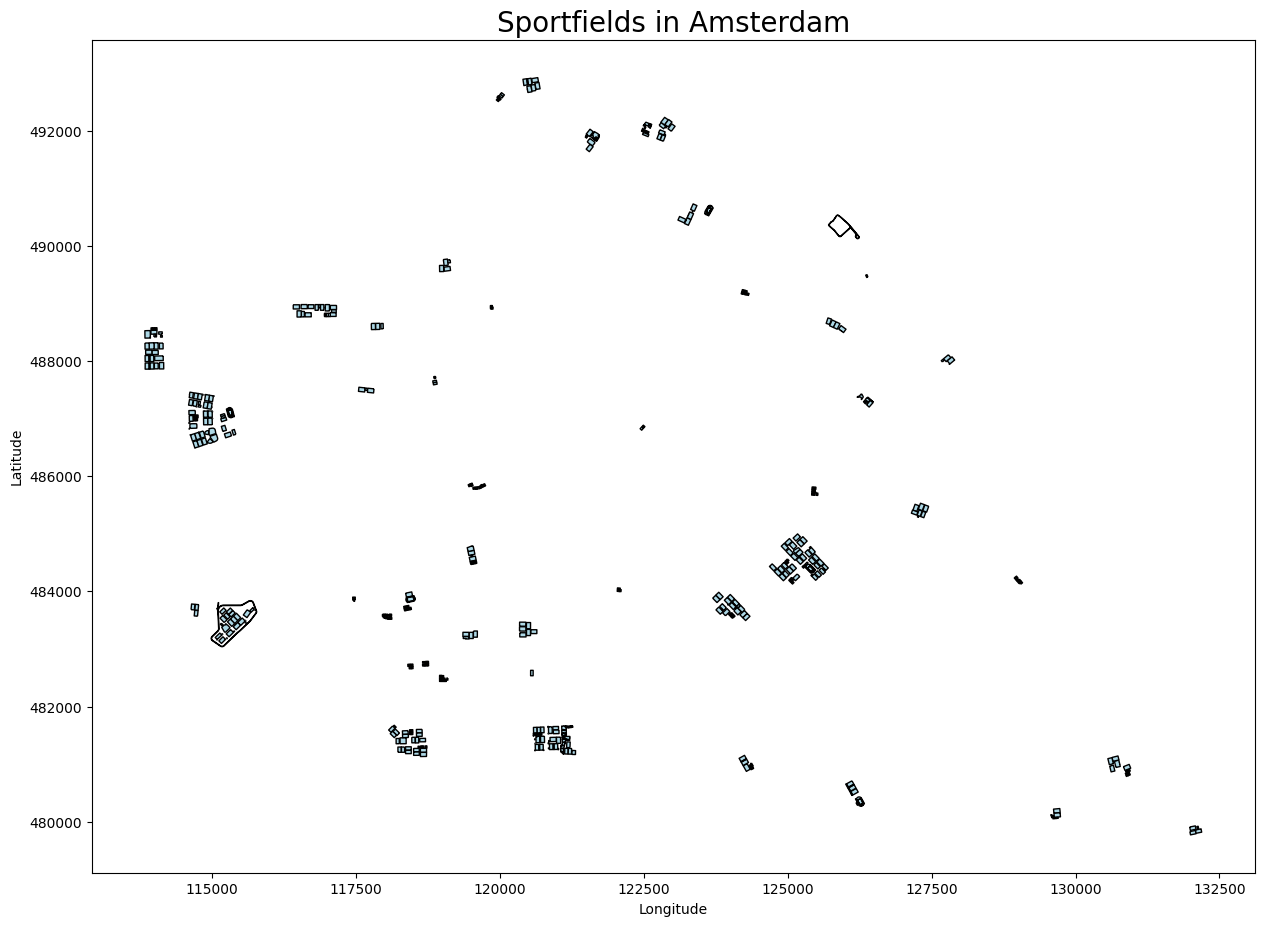

In [4]:
# Plot the data
fig, ax = plt.subplots(figsize=(15, 15))  
sportsvelden.plot(ax=ax, color="lightblue", edgecolor="black")

# Add title and labels
ax.set_title("Sportfields in Amsterdam", fontsize=20)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

### Question 2: Calculating Moran’s I, using a function

In [5]:
def calculate_morans_i(W,y):
    weight = weights.Queen.from_dataframe(W, ids=y, silence_warnings=True)
    mi = esda.Moran(W[y], weight)
    I = mi.I
    pi = mi.p_sim
    return (I, pi)
print('The Maron I and p values are the following: ', calculate_morans_i(sportvelden, 'OPPERVLAKT')) # We choose a numerical variable, in this case the surface area 

The Maron I and p values are the following:  (0.3513929553816942, 0.001)


### ADDITONAL 
A value of 0.351 is positive, indicating that sport fields with similar sizes tend to be near each other. In other words, there's some clustering of similar-sized fields across the area you're analyzing. Along with Moran's I, you can compute the p-value to check if this clustering is statistically significant. This will help you understand whether the observed spatial autocorrelation is due to a real pattern or just random chance

### QUESTION 3 

In [6]:
def standardize_weights(W):
    w_queen = weights.Queen.from_dataframe(W,  ids='GUID', use_index=True, silence_warnings=True)
    w_queen.transform = 'R' 
    print(w_queen['{6B7D7AEB-E108-4260-AB4C-318B84E1BFB9}']) #checking if the transform is completed
    return (w_queen)

standardize_weights(sportsvelden)

{'{AFA3616C-4C77-49B7-8E08-55CE0A9294BF}': 0.5, '{DEF59CA4-52BE-4A77-B077-62934F6D9A5E}': 0.5}


### ADDITIONAL 
This is the same ID used in question 1, which specifies that the neighbors must be 'touching,' following the Queen contiguity rule. Standardization divides 1 by the number of neighbors, which is why the weights are 0.5 and 0.5

### Question 4

In [7]:
sportsvelden.crs #not a mandatory step. However, it helps us understand our data (units which we will apply the threshold)

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [8]:
def create_distance_weights(sportvelden, threshold):  
    
    # Create Distance Band weights
    #the coordinates will be taken from the dataframe. The coordinates are automatically the center of the chosen polygon, which is specified by the "GUID" column
    #by setting binary=False we assign different weights to different neighbors within the radious circle based on how far they are from the specific coordinate
    w_dist = weights.DistanceBand.from_dataframe(sportvelden, threshold, ids='GUID', binary = False, silence_warnings=True) 
    
    # Return the weights as a dictionary
    return w_dist

weight_matrix = create_distance_weights(sportsvelden, threshold=100)
print(weight_matrix['{8FED7F2A-9EDD-43B5-9677-B2F0FAE09EE5}'])

{'{6E813871-774F-410E-BBB1-2F83C5B28619}': 0.01071496233627462, '{E1B07C89-FC56-4ECF-B066-E64B2FFBCD59}': 0.01071032567197251, '{BDAC70C9-CF14-4454-8A5B-50BF18718257}': 0.026809601421143154, '{2DF7E50F-109F-42F3-AA89-99032E6EFCF6}': 0.012706205703114015, '{5FA54E1A-7A79-4C14-8AF6-6C1540203E55}': 0.013046227795163191, '{35727819-7F8D-4C18-9D0C-B6FD5DA946BC}': 0.0597250232061927, '{062EE7F8-83FE-4999-8BFE-64137ED98E56}': 0.013030643049676889, '{16FC0E2F-C1A3-4389-85A6-710C4CEB9C8A}': 0.02719278515413987, '{8FE7D3DE-A1CF-4D4D-8702-65AFE5F6DB4D}': 0.015589658717485865, '{8AC7B0A5-8F5F-4B46-91DA-2DDB35506994}': 0.060809304269958106, '{7FF36AA5-0D1F-4DE7-84F0-AE50C36DE798}': 0.01842826577478589, '{CAAA4655-C859-47FC-8AC8-6900B53466FD}': 0.01843618325655464, '{E8616C1C-498D-4D26-8136-C01E98126D00}': 0.02692648969039768}


### QUESTION 5

C:\Users\maria\AppData\Local\Temp\ipykernel_19900\684584576.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_queen = weights.Queen.from_dataframe(W, silence_warnings=True)


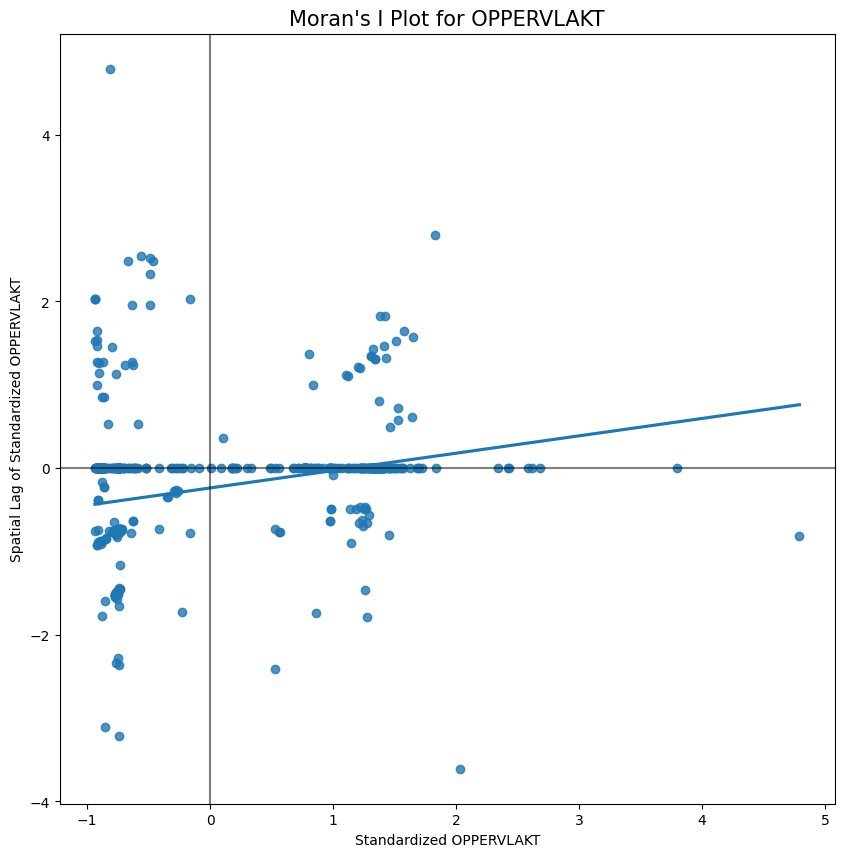

In [9]:
def plot_moran(W, y):
    
    # Create the spatial weights matrix (Queen contiguity)
    w_queen = weights.Queen.from_dataframe(W, silence_warnings=True)

    # Create spatial lag of the attribute array y
    W['w_OPPERVLAKT'] = weights.lag_spatial(w_queen, W[y])

    # Standardize both the attribute values and their spatial lags
    W['OPPERVLAKT_std'] = (W['OPPERVLAKT'] - W['OPPERVLAKT'].mean()) / W['OPPERVLAKT'].std()
    W['w_OPPERVLAKT_std'] = weights.lag_spatial(w_queen, W['OPPERVLAKT_std'])

    # Setup the figure and axis for the Moran plot
    f, ax = plt.subplots(1, figsize=(10, 10))

    # Create the Moran plot using seaborn regplot
    sns.regplot(x='OPPERVLAKT_std', y='w_OPPERVLAKT_std', data=W, ci=None)

    # Add vertical and horizontal lines to denote zero axes
    plt.axvline(0, c='k', alpha=0.5)
    plt.axhline(0, c='k', alpha=0.5)

    # Add titles and labels
    ax.set_title(f"Moran's I Plot for {y}", fontsize=15)
    ax.set_xlabel(f'Standardized {y}')
    ax.set_ylabel(f'Spatial Lag of Standardized {y}')

    # Step 8: Save plot into an image file
    plt.savefig(f'moran_plot_{y}.png', dpi=150, bbox_inches='tight')

    # Step 9: Display the plot
    plt.show()

# Example call to the function:
plot_moran(sportsvelden, 'OPPERVLAKT')
